<a href="https://colab.research.google.com/github/albercej/zug/blob/master/StockScreenAndRank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Title:
Simple Factor Investing Based Stock Screening/Ranking Tool**

Description : 
This is a workbook that allows you to use Factor Investing where you select a number of factors from Yahoo Statistics and aggregate the info over multiple stocks to develop a composite score for each stock. These are then ranked by this score to produce a short list of "Top Quartile" stocks which are then compared against the median of the other quartiles of stocks to see if method is effective

Author:
zhijingeu@yahoo.com 

Last Rev 12 Feb 2021

In [11]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date
import time
import random
from tqdm import tqdm
from pandas_datareader import data
from scipy.stats import zscore
import matplotlib.pyplot as plt

In [3]:
#function to extract statistics for each stock
def get_key_stats(tgt_website):
 
    # The web page is make up of several html table. By calling read_html function.
    # all the tables are retrieved in dataframe format.
    # Next is to append all the table and transpose it to give a nice one row data.
    df_list = pd.read_html(tgt_website)
    df_statistics = df_list[0]
 
    for df in df_list[1:]:
        df_statistics = df_statistics.append(df)
 
    # Transpose the result to make all data in single row
    return df_statistics.set_index(0).T

In [4]:
#function to find the last recent weekday for a given date e.g. Fri if Sat or Sun 

def lastBusDay(enterdate):
    if enterdate.weekday()==6:
        lastBusDay = datetime(year=enterdate.year, month=enterdate.month, day=enterdate.day-2)
    elif enterdate.weekday()==5:
        lastBusDay = datetime(year=enterdate.year, month=enterdate.month, day=enterdate.day-1)
    else:
        lastBusDay = enterdate
    return lastBusDay

In [5]:
#Randomly selects a user defined no of stocks based on the variable below from a long list of stocks from SGX,HKSE or S&P500

noOfCounters=30

#SGX
total_list=['1A0.SI', '1A1.SI', '1A4.SI', '1B0.SI', '1B1.SI', '1B6.SI', '1C0.SI', '1C3.SI', '1C5.SI', '1D0.SI', '1D1.SI', '1D3.SI', '1D4.SI', '1D5.SI', '1D8.SI', '1E3.SI', '1E6.SI', '1F0.SI', '1F1.SI', '1F2.SI', '1F3.SI', '1F4.SI', '1G1.SI', '1G6.SI', '1H2.SI', '1H3.SI', '1H4.SI', '1H8.SI', '1J0.SI', '1J3.SI', '1J4.SI', '1J5.SI', '1J7.SI', '40B.SI', '40D.SI', '40E.SI', '40F.SI', '40N.SI', '40S.SI', '40T.SI', '40U.SI', '40V.SI', '40W.SI', '41A.SI', '41B.SI', '41F.SI', '41H.SI', '41O.SI', '41S.SI', '41T.SI', '42C.SI', '42D.SI', '42E.SI', '42F.SI', '42G.SI', '42L.SI', '42N.SI', '42R.SI', '42S.SI', '42U.SI', '42W.SI', '42Z.SI', '43A.SI', '43B.SI', '43E.SI', '43F.SI', '43P.SI', '43Q.SI', '500.SI', '502.SI', '504.SI', '505.SI', '508.SI', '510.SI', '528.SI', '532.SI', '533.SI', '539.SI', '540.SI', '541.SI', '543.SI', '544.SI', '546.SI', '554.SI', '557.SI', '558.SI', '561.SI', '564.SI', '566.SI', '567.SI', '569.SI', '570.SI', '571.SI', '573.SI', '575.SI', '578.SI', '579.SI', '580.SI', '581.SI', '583.SI', '585.SI', '586.SI', '588.SI', '594.SI', '595.SI', '5AB.SI', '5AE.SI', '5AI.SI', '5AL.SI', '5AU.SI', '5BI.SI', '5BS.SI', '5CF.SI', '5CN.SI', '5CP.SI', '5CR.SI', '5CT.SI', '5DD.SI', '5DL.SI', '5DM.SI', '5DO.SI', '5DP.SI', '5DS.SI', '5DX.SI', '5EB.SI', '5EF.SI', '5EG.SI', '5EK.SI', '5EL.SI', '5EV.SI', '5EW.SI', '5F4.SI', '5F7.SI', '5FH.SI', '5FL.SI', '5FW.SI', '5FX.SI', '5G1.SI', '5G2.SI', '5G3.SI', '5G4.SI', '5G9.SI', '5GD.SI', '5GF.SI', '5GI.SI', '5GJ.SI', '5GZ.SI', '5H0.SI', '5HC.SI', '5HG.SI', '5HH.SI', '5HT.SI', '5HV.SI', '5I0.SI', '5I1.SI', '5I4.SI', '5IC.SI', '5IF.SI', '5IG.SI', '5JK.SI', '5JS.SI', '5KI.SI', '5LE.SI', '5LY.SI', '5MD.SI', '5ML.SI', '5NG.SI', '5NK.SI', '5OC.SI', '5PD.SI', '5PF.SI', '5PI.SI', '5PO.SI', '5QT.SI', '5RA.SI', '5RC.SI', '5RF.SI', '5TN.SI', '5TP.SI', '5UJ.SI', '5UL.SI', '5UN.SI', '5UX.SI', '5WF.SI', '5WG.SI', '5WV.SI', 'A04.SI', 'A26.SI', 'A27.SI', 'A34.SI', 'A50.SI', 'A52.SI', 'A7RU.SI', 'ADN.SI', 'ADQU.SI', 'AGS.SI', 'AJ2.SI', 'AOF.SI', 'AP4.SI', 'AUE.SI', 'AVM.SI', 'AVV.SI', 'AVX.SI', 'AWC.SI', 'AWE.SI', 'AWG.SI', 'AWI.SI', 'AWK.SI', 'AWM.SI', 'AWO.SI', 'AWS.SI', 'AWV.SI', 'AWX.SI', 'AWZ.SI', 'AXB.SI', 'AYB.SI', 'AYD.SI', 'AYL.SI', 'AYN.SI', 'AYV.SI', 'AZA.SI', 'AZG.SI', 'AZR.SI', 'AZT.SI', 'AZY.SI', 'AZZ.SI', 'B07.SI', 'B16.SI', 'B26.SI', 'B28.SI', 'B49.SI', 'B58.SI', 'B61.SI', 'B69.SI', 'B7K.SI', 'B9S.SI', 'BAC.SI', 'BAI.SI', 'BAZ.SI', 'BBP.SI', 'BBW.SI', 'BCD.SI', 'BCV.SI', 'BCY.SI', 'BCZ.SI', 'BDA.SI', 'BDF.SI', 'BDR.SI', 'BDU.SI', 'BDX.SI', 'BEC.SI', 'BEH.SI', 'BEI.SI', 'BEW.SI', 'BEZ.SI', 'BFI.SI', 'BFK.SI', 'BFT.SI', 'BFU.SI', 'BHD.SI', 'BHK.SI', 'BHO.SI', 'BHQ.SI', 'BHU.SI', 'BIP.SI', 'BIX.SI', 'BJD.SI', 'BJL.SI', 'BJW.SI', 'BJZ.SI', 'BKA.SI', 'BKK.SI', 'BKV.SI', 'BKW.SI', 'BKX.SI', 'BKY.SI', 'BLA.SI', 'BLH.SI', 'BLL.SI', 'BLR.SI', 'BLU.SI', 'BLW.SI', 'BLZ.SI', 'BMT.SI', 'BN2.SI', 'BN4.SI', 'BNE.SI', 'BOU.SI', 'BPF.SI', 'BQC.SI', 'BQD.SI', 'BQF.SI', 'BQM.SI', 'BQN.SI', 'BRD.SI', 'BRS.SI', 'BS6.SI', 'BSL.SI', 'BTE.SI', 'BTF.SI', 'BTG.SI', 'BTJ.SI', 'BTM.SI', 'BTP.SI', 'BTX.SI', 'BVA.SI', 'BVP.SI', 'BVQ.SI', 'BWM.SI', 'BXE.SI', 'C04.SI', 'C05.SI', 'C06.SI', 'C07.SI', 'C09.SI', 'C13.SI', 'C29.SI', 'C31.SI', 'C33.SI', 'C41.SI', 'C50.SI', 'C52.SI', 'C6L.SI', 'C76.SI', 'C8R.SI', 'C92.SI', 'C9Q.SI', 'CC3.SI', 'CEDU.SI', 'CEE.SI', 'CGN.SI', 'CH8.SI', 'CHJ.SI', 'CHZ.SI', 'CIN.SI', 'CJLU.SI', 'CJN.SI', 'CLN.SI', 'CNE.SI', 'CTN.SI', 'CTO.SI', 'CY6U.SI', 'CYW.SI', 'CZ4.SI', 'D01.SI', 'D03.SI', 'D05.SI', 'D11.SI', 'D6U.SI', 'D79.SI', 'DM0.SI', 'DRX.SI', 'DU4.SI', 'E16.SI', 'E27.SI', 'E28.SI', 'E3B.SI', 'E5H.SI', 'E8Z.SI', 'EB5.SI', 'EB7.SI', 'EH5.SI', 'ER0.SI', 'F03.SI', 'F10.SI', 'F13.SI','F17.SI', 'F1E.SI', 'F31.SI', 'F34.SI', 'F3V.SI', 'F83.SI', 'F86.SI', 'F99.SI', 'F9D.SI', 'FQ7.SI', 'G0I.SI', 'G13.SI', 'G20.SI', 'G41.SI', 'G50.SI', 'G92.SI', 'GU5.SI', 'H02.SI', 'H07.SI', 'H12.SI', 'H13.SI', 'H15.SI', 'H17.SI', 'H18.SI', 'H19.SI', 'H20.SI', 'H22.SI', 'H30.SI', 'H78.SI', 'I06.SI', 'I07.SI', 'I11.SI', 'I15.SI', 'I9T.SI', 'IW5.SI', 'IX2.SI', 'J03.SI', 'J17.SI', 'J18.SI', 'J2T.SI', 'J36.SI', 'J37.SI', 'JLB.SI', 'K03.SI', 'K1Q.SI', 'K22.SI', 'K29.SI', 'K75.SI', 'KJ5.SI', 'KUH.SI', 'L02.SI', 'L03.SI', 'L09.SI', 'L19.SI', 'L23.SI', 'L38.SI', 'L46.SI', 'LJ3.SI', 'LS9.SI', 'M01.SI', 'M03.SI', 'M04.SI', 'M05.SI', 'M11.SI', 'M14.SI', 'M15.SI', 'M1Z.SI', 'M30.SI', 'MF6.SI', 'MIJ.SI', 'MR7.SI', 'MV4.SI', 'N01.SI', 'N02.SI', 'N08.SI', 'N0Z.SI', 'N32.SI', 'N4E.SI', 'NC2.SI', 'NEX.SI', 'NHD.SI', 'NO4.SI', 'NPW.SI', 'NR7.SI', 'NS8U.SI', 'O10.SI', 'O2I.SI', 'O32.SI', 'O39.SI', 'O9E.SI', 'OAJ.SI', 'OMK.SI', 'OTX.SI', 'OU8.SI', 'OV8.SI', 'OYY.SI', 'P34.SI', 'P36.SI', 'P52.SI', 'P74.SI', 'P8A.SI', 'P8Z.SI', 'P9D.SI', 'PA3.SI', 'PH0.SI', 'Q01.SI', 'Q0F.SI', 'Q0X.SI', 'QC7.SI', 'QF6.SI', 'QS9.SI', 'QZG.SI', 'R14.SI', 'RCU.SI', 'RE4.SI', 'RF1U.SI', 'RF7.SI', 'RQ1.SI', 'RS1.SI', 'S07.SI', 'S08.SI', 'S19.SI', 'S20.SI', 'S29.SI', 'S3N.SI', 'S44.SI', 'S46.SI', 'S51.SI', 'S56.SI', 'S58.SI', 'S59.SI', 'S61.SI', 'S63.SI', 'S69.SI', 'S71.SI', 'S7OU.SI', 'S7P.SI', 'S85.SI', 'S91.SI', 'S9B.SI', 'SJY.SI', 'SK3.SI', 'STP.SI', 'T12.SI', 'T13.SI', 'T14.SI', 'T19.SI', 'T24.SI', 'T39.SI', 'T41.SI', 'T43.SI', 'T4B.SI', 'TQ5.SI', 'U04.SI', 'U06.SI', 'U09.SI', 'U13.SI', 'U14.SI', 'U6C.SI', 'U77.SI', 'U96.SI', 'U9E.SI', 'UD1U.SI', 'UD2.SI', 'UV1.SI', 'V01.SI', 'V03.SI', 'V2Y.SI', 'V3M.SI', 'VFP.SI', 'VL6.SI', 'W05.SI', 'WPC.SI', 'XCF.SI', 'Y03.SI', 'Y06.SI', 'Y35.SI', 'Y45.SI', 'Y92.SI', 'YYB.SI', 'Z25.SI', 'Z59.SI', 'Z74.SI', 'I49.SI']

#HKSE
#total_list=['0001.HK', '0003.HK', '0004.HK', '0005.HK', '0006.HK', '0007.HK', '0008.HK', '0009.HK', '0010.HK', '0011.HK', '0012.HK', '0014.HK', '0015.HK', '0016.HK', '0017.HK', '0018.HK', '0019.HK', '0020.HK', '0021.HK', '0023.HK', '0024.HK', '0025.HK', '0027.HK', '0028.HK', '0029.HK', '0030.HK', '0031.HK', '0032.HK', '0033.HK', '0034.HK', '0035.HK', '0036.HK', '0037.HK', '0038.HK', '0039.HK', '0040.HK', '0041.HK', '0042.HK', '0043.HK', '0045.HK', '0046.HK', '0047.HK', '0048.HK', '0050.HK', '0051.HK', '0052.HK', '0053.HK', '0055.HK', '0056.HK', '0057.HK', '0058.HK', '0059.HK', '0060.HK', '0061.HK', '0062.HK', '0063.HK', '0064.HK', '0065.HK', '0068.HK', '0069.HK', '0070.HK', '0071.HK', '0072.HK', '0075.HK', '0076.HK', '0077.HK', '0078.HK', '0079.HK', '0081.HK', '0082.HK', '0083.HK', '0084.HK', '0085.HK', '0086.HK', '0089.HK', '0091.HK', '0092.HK', '0094.HK', '0095.HK', '0096.HK', '0097.HK', '0098.HK', '0099.HK', '0100.HK', '0101.HK', '0102.HK', '0103.HK', '0104.HK', '0105.HK', '0106.HK', '0107.HK', '0108.HK', '0109.HK', '0110.HK', '0111.HK', '0112.HK', '0113.HK', '0114.HK', '0115.HK', '0116.HK', '0117.HK', '0119.HK', '0120.HK', '0122.HK', '0123.HK', '0124.HK', '0125.HK', '0126.HK', '0127.HK', '0128.HK', '0129.HK', '0130.HK', '0131.HK', '0132.HK', '0135.HK', '0136.HK', '0137.HK', '0138.HK', '0139.HK', '0141.HK', '0142.HK', '0143.HK', '0144.HK', '0145.HK', '0147.HK', '0148.HK', '0149.HK', '0150.HK', '0151.HK', '0152.HK', '0153.HK', '0154.HK', '0156.HK', '0158.HK', '0159.HK', '0160.HK', '0162.HK', '0164.HK', '0165.HK', '0166.HK', '0167.HK', '0168.HK', '0171.HK', '0173.HK', '0174.HK', '0175.HK', '0176.HK', '0177.HK', '0178.HK', '0179.HK', '0180.HK', '0181.HK', '0182.HK', '0183.HK', '0184.HK', '0185.HK', '0186.HK', '0187.HK', '0188.HK', '0189.HK', '0190.HK', '0193.HK', '0194.HK', '0196.HK', '0197.HK', '0199.HK', '0200.HK', '0201.HK', '0202.HK', '0206.HK', '0207.HK', '0208.HK', '0209.HK', '0210.HK', '0211.HK', '0213.HK', '0214.HK', '0215.HK', '0216.HK', '0217.HK', '0218.HK', '0219.HK', '0220.HK', '0221.HK', '0222.HK', '0223.HK', '0224.HK', '0225.HK', '0226.HK', '0227.HK', '0229.HK', '0230.HK', '0231.HK', '0232.HK', '0234.HK', '0235.HK', '0238.HK', '0240.HK', '0241.HK', '0242.HK', '0243.HK', '0244.HK', '0245.HK', '0247.HK', '0248.HK', '0250.HK', '0251.HK', '0252.HK', '0253.HK', '0255.HK', '0256.HK', '0257.HK', '0258.HK', '0259.HK', '0260.HK', '0261.HK', '0262.HK', '0263.HK', '0264.HK', '0265.HK', '0266.HK', '0267.HK', '0268.HK', '0269.HK', '0270.HK', '0271.HK', '0272.HK', '0273.HK', '0274.HK', '0275.HK', '0276.HK', '0279.HK', '0280.HK', '0281.HK', '0282.HK', '0285.HK', '0286.HK', '0287.HK', '0288.HK', '0289.HK', '0290.HK', '0291.HK', '0292.HK', '0293.HK', '0294.HK', '0295.HK', '0296.HK', '0297.HK', '0298.HK', '0299.HK', '0303.HK', '0305.HK', '0306.HK', '0308.HK', '0309.HK', '0311.HK', '0312.HK', '0313.HK', '0315.HK', '0316.HK', '0317.HK', '0318.HK', '0320.HK', '0321.HK', '0322.HK', '0323.HK', '0327.HK', '0328.HK', '0329.HK', '0330.HK', '0331.HK', '0332.HK', '0333.HK', '0334.HK', '0335.HK', '0336.HK', '0337.HK', '0338.HK', '0340.HK', '0341.HK', '0342.HK', '0343.HK', '0345.HK', '0346.HK', '0347.HK', '0348.HK', '0351.HK', '0352.HK', '0353.HK', '0354.HK', '0355.HK', '0357.HK', '0358.HK', '0359.HK', '0360.HK', '0361.HK', '0362.HK', '0363.HK', '0365.HK', '0366.HK', '0367.HK', '0369.HK', '0370.HK', '0371.HK', '0372.HK', '0373.HK', '0374.HK', '0375.HK', '0376.HK', '0377.HK', '0378.HK', '0379.HK', '0380.HK', '0381.HK', '0383.HK', '0384.HK', '0385.HK', '0386.HK', '0387.HK', '0388.HK', '0389.HK', '0391.HK', '0392.HK', '0393.HK', '0395.HK', '0396.HK', '0397.HK', '0398.HK', '0399.HK', '0400.HK', '0401.HK', '0403.HK', '0405.HK', '0406.HK', '0408.HK', '0410.HK', '0411.HK', '0412.HK', '0413.HK', '0416.HK', '0417.HK', '0418.HK', '0419.HK', '0420.HK', '0422.HK', '0423.HK', '0425.HK', '0426.HK', '0430.HK', '0431.HK', '0432.HK', '0433.HK', '0434.HK', '0435.HK', '0436.HK', '0438.HK', '0439.HK', '0440.HK', '0442.HK', '0449.HK', '0450.HK', '0451.HK', '0455.HK', '0456.HK', '0458.HK', '0459.HK', '0460.HK', '0465.HK', '0468.HK', '0471.HK', '0472.HK', '0474.HK', '0475.HK', '0476.HK', '0479.HK', '0480.HK', '0482.HK', '0483.HK', '0484.HK', '0485.HK', '0487.HK', '0488.HK', '0489.HK', '0491.HK', '0493.HK', '0494.HK', '0495.HK', '0496.HK', '0497.HK', '0498.HK', '0500.HK', '0505.HK', '0506.HK', '0508.HK', '0509.HK', '0512.HK', '0513.HK', '0515.HK', '0517.HK', '0518.HK', '0519.HK', '0520.HK', '0521.HK', '0522.HK', '0524.HK', '0527.HK', '0528.HK', '0529.HK', '0530.HK', '0531.HK', '0532.HK', '0533.HK', '0538.HK', '0539.HK', '0540.HK', '0542.HK', '0546.HK', '0547.HK', '0548.HK', '0551.HK', '0553.HK', '0554.HK', '0555.HK', '0556.HK', '0558.HK', '0559.HK', '0560.HK', '0563.HK', '0564.HK', '0565.HK', '0567.HK', '0568.HK', '0570.HK', '0571.HK', '0572.HK', '0573.HK', '0575.HK', '0576.HK', '0577.HK', '0578.HK', '0579.HK', '0580.HK', '0581.HK', '0583.HK', '0585.HK', '0588.HK', '0593.HK', '0595.HK', '0598.HK', '0599.HK', '0600.HK', '0601.HK', '0603.HK', '0604.HK', '0605.HK', '0607.HK', '0608.HK', '0609.HK', '0610.HK', '0611.HK', '0613.HK', '0616.HK', '0617.HK', '0618.HK', '0619.HK', '0620.HK', '0621.HK', '0623.HK', '0626.HK', '0627.HK', '0628.HK', '0629.HK', '0631.HK', '0632.HK', '0633.HK', '0635.HK', '0636.HK', '0637.HK', '0638.HK', '0639.HK', '0640.HK', '0641.HK', '0643.HK', '0645.HK', '0647.HK', '0650.HK', '0651.HK', '0653.HK', '0656.HK', '0658.HK', '0660.HK', '0661.HK', '0662.HK', '0663.HK', '0665.HK', '0667.HK', '0668.HK', '0669.HK', '0670.HK', '0674.HK', '0675.HK', '0676.HK', '0678.HK', '0679.HK', '0680.HK', '0681.HK', '0682.HK', '0683.HK', '0684.HK', '0685.HK', '0686.HK', '0688.HK', '0690.HK', '0691.HK', '0693.HK', '0694.HK', '0695.HK', '0697.HK', '0698.HK', '0699.HK', '0701.HK', '0702.HK', '0703.HK', '0704.HK', '0706.HK', '0707.HK', '0708.HK', '0709.HK', '0710.HK', '0711.HK', '0713.HK', '0715.HK', '0716.HK', '0717.HK', '0718.HK', '0719.HK', '0720.HK', '0722.HK', '0724.HK', '0725.HK', '0726.HK', '0727.HK', '0728.HK', '0729.HK', '0730.HK', '0731.HK', '0732.HK', '0733.HK', '0736.HK', '0737.HK', '0738.HK', '0745.HK', '0746.HK', '0747.HK', '0750.HK', '0751.HK', '0753.HK', '0754.HK', '0755.HK', '0756.HK', '0758.HK', '0759.HK', '0760.HK', '0763.HK', '0764.HK', '0765.HK', '0766.HK', '0767.HK', '0769.HK', '0771.HK', '0772.HK', '0775.HK', '0776.HK', '0777.HK', '0778.HK', '0780.HK', '0784.HK', '0787.HK', '0788.HK', '0789.HK', '0798.HK', '0799.HK', '0801.HK', '0802.HK', '0803.HK', '0804.HK', '0806.HK', '0809.HK', '0811.HK', '0812.HK', '0814.HK', '0815.HK', '0816.HK', '0817.HK', '0818.HK', '0819.HK', '0821.HK', '0822.HK', '0823.HK', '0825.HK', '0826.HK', '0827.HK', '0828.HK', '0829.HK', '0830.HK', '0832.HK', '0833.HK', '0834.HK', '0836.HK', '0837.HK', '0838.HK', '0840.HK', '0841.HK', '0842.HK', '0844.HK', '0845.HK', '0848.HK', '0852.HK', '0853.HK', '0854.HK', '0855.HK', '0856.HK', '0857.HK', '0859.HK', '0860.HK', '0861.HK', '0862.HK', '0863.HK', '0864.HK', '0865.HK', '0866.HK', '0867.HK', '0868.HK', '0869.HK', '0871.HK', '0872.HK', '0874.HK', '0875.HK', '0876.HK', '0877.HK', '0878.HK', '0880.HK', '0881.HK', '0882.HK', '0883.HK', '0885.HK', '0886.HK', '0887.HK', '0888.HK', '0889.HK', '0891.HK', '0893.HK', '0894.HK', '0895.HK', '0896.HK', '0897.HK', '0899.HK', '0900.HK', '0902.HK', '0906.HK', '0907.HK', '0908.HK', '0910.HK', '0911.HK', '0912.HK', '0914.HK', '0915.HK', '0916.HK', '0918.HK', '0919.HK', '0921.HK', '0922.HK', '0923.HK', '0925.HK', '0926.HK', '0927.HK', '0928.HK', '0929.HK', '0934.HK', '0935.HK', '0936.HK', '0939.HK', '0941.HK', '0943.HK', '0945.HK', '0947.HK', '0948.HK', '0950.HK', '0951.HK', '0953.HK', '0954.HK', '0956.HK', '0958.HK', '0959.HK', '0960.HK', '0966.HK', '0968.HK', '0969.HK', '0970.HK', '0973.HK', '0974.HK', '0975.HK', '0976.HK', '0978.HK', '0979.HK', '0980.HK', '0981.HK', '0982.HK', '0983.HK', '0984.HK', '0985.HK', '0986.HK', '0988.HK', '0989.HK', '0990.HK', '0991.HK', '0992.HK', '0993.HK', '0994.HK', '0995.HK', '0996.HK', '0997.HK', '0999.HK', '1000.HK', '1001.HK', '1002.HK', '1003.HK', '1004.HK', '1005.HK', '1006.HK', '1007.HK', '1008.HK', '1009.HK', '1011.HK', '1013.HK', '1020.HK', '1022.HK', '1025.HK', '1026.HK', '1027.HK', '1028.HK', '1029.HK', '1031.HK', '1033.HK', '1034.HK', '1035.HK', '1036.HK', '1038.HK', '1039.HK', '1041.HK', '1043.HK', '1044.HK', '1045.HK', '1046.HK', '1047.HK', '1049.HK', '1050.HK', '1051.HK', '1053.HK', '1055.HK', '1057.HK', '1060.HK', '1061.HK', '1063.HK', '1064.HK', '1065.HK', '1066.HK', '1068.HK', '1069.HK', '1070.HK', '1071.HK', '1072.HK', '1073.HK', '1075.HK', '1076.HK', '1079.HK', '1080.HK', '1082.HK', '1083.HK', '1084.HK', '1085.HK', '1087.HK', '1088.HK', '1089.HK', '1090.HK', '1091.HK', '1096.HK', '1097.HK', '1099.HK', '1100.HK', '1101.HK', '1102.HK', '1103.HK', '1104.HK', '1105.HK', '1106.HK', '1107.HK', '1108.HK', '1109.HK', '1110.HK', '1111.HK', '1112.HK', '1113.HK', '1114.HK', '1115.HK', '1116.HK', '1117.HK', '1118.HK', '1119.HK', '1120.HK', '1122.HK', '1123.HK', '1124.HK', '1125.HK', '1126.HK', '1127.HK', '1128.HK', '1129.HK', '1130.HK', '1131.HK', '1132.HK', '1133.HK', '1134.HK', '1138.HK', '1141.HK', '1142.HK', '1143.HK', '1146.HK', '1148.HK', '1150.HK', '1151.HK', '1152.HK', '1157.HK', '1161.HK', '1164.HK', '1165.HK', '1166.HK', '1168.HK', '1169.HK', '1170.HK', '1172.HK', '1173.HK', '1175.HK', '1176.HK', '1177.HK', '1178.HK', '1180.HK', '1181.HK', '1182.HK', '1183.HK', '1184.HK', '1185.HK', '1186.HK', '1188.HK', '1189.HK', '1191.HK', '1192.HK', '1193.HK', '1194.HK', '1195.HK', '1196.HK', '1198.HK', '1200.HK', '1202.HK', '1203.HK', '1205.HK', '1206.HK', '1207.HK', '1208.HK', '1210.HK', '1211.HK', '1213.HK', '1215.HK', '1216.HK', '1218.HK', '1220.HK', '1222.HK', '1223.HK', '1224.HK', '1229.HK', '1230.HK', '1231.HK', '1233.HK', '1234.HK', '1235.HK', '1237.HK', '1238.HK', '1239.HK', '1240.HK', '1241.HK', '1243.HK', '1245.HK', '1247.HK', '1249.HK', '1250.HK', '1251.HK', '1253.HK', '1255.HK', '1258.HK', '1259.HK', '1260.HK', '1262.HK', '1263.HK', '1265.HK', '1266.HK', '1268.HK', '1269.HK', '1270.HK','1271.HK','1272.HK', '1273.HK', '1275.HK', '1278.HK', '1280.HK', '1281.HK', '1282.HK', '1283.HK', '1285.HK', '1286.HK', '1288.HK', '1289.HK', '1290.HK', '1292.HK', '1293.HK', '1296.HK', '1297.HK', '1299.HK', '1300.HK', '1301.HK', '1302.HK', '1305.HK', '1308.HK', '1310.HK', '1312.HK', '1313.HK', '1314.HK', '1317.HK', '1319.HK', '1321.HK', '1323.HK', '1326.HK', '1328.HK', '1329.HK', '1330.HK', '1332.HK', '1333.HK', '1335.HK', '1336.HK', '1337.HK', '1338.HK', '1339.HK', '1340.HK', '1341.HK', '1345.HK', '1346.HK', '1347.HK', '1348.HK', '1349.HK', '1355.HK', '1357.HK', '1358.HK', '1359.HK', '1360.HK', '1361.HK', '1362.HK', '1363.HK', '1365.HK', '1367.HK', '1368.HK', '1370.HK', '1372.HK', '1373.HK', '1375.HK', '1378.HK', '1380.HK', '1381.HK', '1386.HK', '1387.HK', '1388.HK', '1389.HK', '1393.HK', '1395.HK', '1396.HK', '1397.HK', '1398.HK', '1399.HK', '1401.HK', '1417.HK', '1418.HK', '1419.HK', '1420.HK', '1421.HK', '1425.HK', '1426.HK', '1427.HK', '1430.HK', '1431.HK', '1432.HK', '1443.HK', '1446.HK', '1447.HK', '1448.HK', '1450.HK', '1451.HK', '1452.HK', '1456.HK', '1458.HK', '1459.HK', '1461.HK', '1462.HK', '1466.HK', '1469.HK', '1470.HK', '1475.HK', '1476.HK', '1478.HK', '1480.HK', '1483.HK', '1486.HK', '1488.HK', '1492.HK', '1495.HK', '1496.HK', '1498.HK', '1499.HK', '1500.HK', '1501.HK', '1503.HK', '1508.HK', '1509.HK', '1513.HK', '1515.HK', '1520.HK', '1521.HK', '1522.HK', '1523.HK', '1526.HK', '1527.HK', '1528.HK', '1530.HK', '1532.HK', '1536.HK', '1540.HK', '1545.HK', '1546.HK', '1547.HK', '1548.HK', '1549.HK', '1552.HK', '1555.HK', '1557.HK', '1558.HK', '1559.HK', '1560.HK', '1561.HK', '1563.HK', '1565.HK', '1566.HK', '1568.HK', '1569.HK', '1570.HK', '1572.HK', '1573.HK', '1575.HK', '1576.HK', '1577.HK', '1578.HK', '1579.HK', '1580.HK', '1581.HK', '1582.HK', '1583.HK', '1585.HK', '1586.HK', '1587.HK', '1588.HK', '1589.HK', '1591.HK', '1592.HK', '1593.HK', '1596.HK', '1598.HK', '1599.HK', '1600.HK', '1608.HK', '1609.HK', '1610.HK', '1611.HK', '1613.HK', '1615.HK', '1616.HK', '1618.HK', '1620.HK', '1621.HK', '1622.HK', '1626.HK', '1627.HK', '1628.HK', '1629.HK', '1630.HK', '1631.HK', '1632.HK', '1633.HK', '1635.HK', '1636.HK', '1637.HK', '1638.HK', '1639.HK', '1640.HK', '1647.HK', '1649.HK', '1651.HK', '1652.HK', '1653.HK', '1655.HK', '1656.HK', '1658.HK', '1659.HK', '1660.HK', '1661.HK', '1662.HK', '1665.HK', '1666.HK', '1667.HK', '1668.HK', '1669.HK', '1671.HK', '1672.HK', '1673.HK', '1675.HK', '1676.HK', '1678.HK', '1679.HK', '1681.HK', '1682.HK', '1683.HK', '1685.HK', '1686.HK', '1689.HK', '1690.HK', '1692.HK', '1693.HK', '1696.HK', '1697.HK', '1699.HK', '1700.HK', '1701.HK', '1702.HK', '1703.HK', '1705.HK', '1706.HK', '1707.HK', '1708.HK', '1709.HK', '1711.HK', '1712.HK', '1713.HK', '1717.HK', '1718.HK', '1719.HK', '1720.HK', '1721.HK', '1722.HK', '1723.HK', '1725.HK', '1726.HK', '1727.HK', '1728.HK', '1729.HK', '1730.HK', '1731.HK', '1732.HK', '1733.HK', '1735.HK', '1736.HK', '1737.HK', '1738.HK', '1739.HK', '1741.HK', '1742.HK', '1743.HK', '1746.HK', '1747.HK', '1748.HK', '1749.HK', '1750.HK', '1751.HK', '1752.HK', '1753.HK', '1755.HK', '1757.HK', '1758.HK', '1760.HK', '1761.HK', '1762.HK', '1763.HK', '1765.HK', '1766.HK', '1767.HK', '1769.HK', '1771.HK', '1772.HK', '1773.HK', '1775.HK', '1778.HK', '1780.HK', '1781.HK', '1787.HK', '1789.HK', '1790.HK', '1793.HK', '1797.HK', '1798.HK', '1799.HK', '1800.HK', '1801.HK', '1803.HK', '1806.HK', '1808.HK', '1809.HK', '1810.HK', '1812.HK', '1813.HK', '1815.HK', '1816.HK', '1817.HK', '1818.HK', '1821.HK', '1822.HK', '1825.HK', '1827.HK', '1829.HK', '1830.HK', '1831.HK', '1835.HK', '1836.HK', '1837.HK', '1838.HK', '1839.HK', '1842.HK', '1843.HK', '1845.HK', '1846.HK', '1847.HK', '1848.HK', '1849.HK', '1850.HK', '1851.HK', '1853.HK', '1854.HK', '1856.HK', '1857.HK', '1860.HK', '1861.HK', '1862.HK', '1865.HK', '1866.HK', '1867.HK', '1868.HK', '1869.HK', '1870.HK', '1871.HK', '1872.HK', '1873.HK', '1875.HK', '1876.HK', '1877.HK', '1878.HK', '1881.HK', '1882.HK', '1883.HK', '1884.HK', '1885.HK', '1888.HK', '1889.HK', '1890.HK', '1894.HK', '1895.HK', '1896.HK', '1897.HK', '1898.HK', '1899.HK', '1900.HK', '1901.HK', '1902.HK', '1903.HK', '1905.HK', '1906.HK', '1907.HK', '1908.HK', '1909.HK', '1910.HK', '1911.HK', '1913.HK', '1916.HK', '1917.HK', '1918.HK', '1919.HK', '1920.HK', '1921.HK', '1928.HK', '1929.HK', '1930.HK', '1931.HK', '1932.HK', '1933.HK', '1935.HK', '1938.HK', '1939.HK', '1943.HK', '1949.HK', '1951.HK', '1955.HK', '1958.HK', '1960.HK', '1962.HK', '1963.HK', '1966.HK', '1967.HK', '1968.HK', '1969.HK', '1970.HK', '1975.HK', '1977.HK', '1978.HK', '1979.HK', '1980.HK', '1982.HK', '1983.HK', '1985.HK', '1986.HK', '1987.HK', '1988.HK', '1989.HK', '1990.HK', '1991.HK', '1992.HK', '1995.HK', '1996.HK', '1997.HK', '1999.HK', '2000.HK', '2002.HK', '2003.HK', '2005.HK', '2006.HK', '2007.HK', '2008.HK', '2009.HK', '2011.HK', '2012.HK', '2013.HK', '2014.HK', '2016.HK', '2017.HK', '2019.HK', '2022.HK', '2023.HK', '2025.HK', '2028.HK', '2030.HK', '2033.HK', '2038.HK', '2039.HK', '2048.HK', '2051.HK', '2060.HK', '2066.HK', '2068.HK', '2078.HK', '2080.HK', '2083.HK', '2086.HK', '2088.HK', '2098.HK', '2099.HK', '2100.HK', '2103.HK', '2108.HK', '2111.HK', '2112.HK', '2113.HK', '2116.HK', '2118.HK', '2120.HK', '2128.HK', '2133.HK', '2136.HK', '2138.HK', '2139.HK', '2163.HK', '2166.HK', '2168.HK', '2178.HK', '2180.HK', '2181.HK', '2182.HK', '2183.HK', '2186.HK', '2188.HK', '2189.HK', '2193.HK', '2198.HK', '2199.HK', '2202.HK', '2208.HK', '2211.HK', '2212.HK', '2213.HK', '2221.HK', '2222.HK', '2223.HK', '2225.HK', '2226.HK', '2227.HK', '2230.HK', '2231.HK', '2232.HK', '2233.HK', '2236.HK', '2239.HK', '2255.HK', '2258.HK', '2262.HK', '2266.HK', '2268.HK', '2269.HK', '2277.HK', '2278.HK', '2280.HK', '2282.HK', '2283.HK', '2286.HK', '2288.HK', '2292.HK', '2293.HK', '2296.HK', '2298.HK', '2299.HK', '2300.HK', '2302.HK', '2303.HK', '2307.HK', '2309.HK', '2310.HK', '2314.HK', '2318.HK', '2319.HK', '2320.HK', '2322.HK', '2323.HK', '2326.HK', '2328.HK', '2329.HK', '2330.HK', '2331.HK', '2333.HK', '2337.HK', '2338.HK', '2339.HK', '2340.HK', '2341.HK', '2342.HK', '2343.HK', '2345.HK', '2349.HK', '2355.HK', '2356.HK', '2358.HK', '2359.HK', '2360.HK', '2362.HK', '2363.HK', '2366.HK', '2368.HK', '2369.HK', '2371.HK', '2377.HK', '2378.HK', '2379.HK', '2382.HK', '2386.HK', '2388.HK', '2389.HK', '2393.HK', '2399.HK', '2400.HK', '2448.HK', '2488.HK', '2500.HK', '2552.HK', '2558.HK', '2588.HK', '2600.HK', '2601.HK', '2606.HK', '2607.HK', '2608.HK', '2611.HK', '2616.HK', '2623.HK', '2628.HK', '2633.HK', '2638.HK', '2660.HK', '2662.HK', '2663.HK', '2666.HK', '2668.HK', '2669.HK', '2680.HK', '2683.HK', '2686.HK', '2689.HK', '2698.HK', '2699.HK', '2700.HK', '2708.HK', '2718.HK', '2722.HK', '2727.HK', '2728.HK', '2738.HK', '2768.HK', '2772.HK', '2777.HK', '2779.HK', '2788.HK', '2789.HK', '2798.HK', '2799.HK', '2858.HK', '2863.HK', '2866.HK', '2868.HK', '2869.HK', '2877.HK', '2878.HK', '2880.HK', '2882.HK', '2883.HK', '2885.HK', '2886.HK', '2888.HK', '2892.HK', '2899.HK', '3300.HK', '3301.HK', '3302.HK', '3306.HK', '3308.HK', '3309.HK', '3311.HK', '3313.HK', '3315.HK', '3316.HK', '3318.HK', '3319.HK', '3320.HK', '3321.HK', '3322.HK', '3323.HK', '3326.HK', '3328.HK', '3330.HK', '3331.HK', '3332.HK', '3333.HK', '3336.HK', '3339.HK', '3344.HK', '3348.HK', '3358.HK', '3360.HK', '3363.HK', '3366.HK', '3368.HK', '3369.HK', '3377.HK', '3378.HK', '3380.HK', '3382.HK', '3383.HK', '3389.HK', '3393.HK', '3395.HK', '3396.HK', '3398.HK', '3399.HK', '3600.HK', '3601.HK', '3603.HK', '3606.HK', '3608.HK', '3613.HK', '3616.HK', '3618.HK', '3623.HK', '3626.HK', '3628.HK', '3633.HK', '3636.HK', '3638.HK', '3639.HK', '3662.HK', '3663.HK', '3666.HK', '3668.HK', '3669.HK', '3678.HK', '3680.HK', '3681.HK', '3683.HK', '3686.HK', '3688.HK', '3689.HK', '3690.HK', '3698.HK', '3699.HK', '3700.HK', '3708.HK', '3709.HK', '3728.HK', '3737.HK', '3759.HK', '3768.HK', '3773.HK', '3778.HK', '3788.HK', '3789.HK', '3798.HK', '3799.HK', '3800.HK', '3808.HK', '3813.HK', '3816.HK', '3818.HK', '3822.HK', '3830.HK', '3833.HK', '3836.HK', '3839.HK', '3848.HK', '3866.HK', '3868.HK', '3869.HK', '3877.HK', '3878.HK', '3882.HK', '3883.HK', '3888.HK', '3889.HK', '3893.HK', '3898.HK', '3899.HK', '3900.HK', '3903.HK', '3908.HK', '3918.HK', '3919.HK', '3928.HK', '3933.HK', '3938.HK', '3939.HK', '3948.HK', '3958.HK', '3963.HK', '3966.HK', '3968.HK', '3969.HK', '3978.HK', '3983.HK', '3988.HK', '3989.HK', '3990.HK', '3992.HK', '3993.HK', '3996.HK', '3997.HK', '3998.HK', '3999.HK', '6030.HK', '6033.HK', '6055.HK', '6058.HK', '6060.HK', '6066.HK', '6069.HK', '6083.HK', '6088.HK', '6090.HK', '6093.HK', '6099.HK', '6100.HK', '6110.HK', '6111.HK', '6117.HK', '6118.HK', '6119.HK', '6122.HK', '6123.HK', '6133.HK', '6136.HK', '6138.HK', '6158.HK', '6160.HK', '6161.HK', '6162.HK', '6166.HK', '6168.HK', '6169.HK', '6178.HK', '6182.HK', '6183.HK', '6186.HK', '6188.HK', '6190.HK', '6196.HK', '6198.HK', '6805.HK', '6806.HK', '6808.HK', '6811.HK', '6816.HK', '6818.HK', '6820.HK', '6822.HK', '6823.HK', '6829.HK', '6836.HK', '6837.HK', '6838.HK', '6839.HK', '6858.HK', '6860.HK', '6862.HK', '6865.HK', '6866.HK', '6868.HK', '6869.HK', '6877.HK', '6878.HK', '6881.HK', '6882.HK', '6885.HK', '6886.HK', '6888.HK', '6889.HK', '6890.HK', '6893.HK', '6896.HK', '6898.HK', '6899.HK', '6908.HK', '6919.HK', '9966.HK', '9988.HK']

#S&P500
#total_list=['AMCR','APTV','BHGE','BKNG','CBRE','CPRI','CTVA','DXC','EVRG','INFO','IQV','LHX','TPR','WELL','MMM','ABT','ABBV','ABMD','ACN','ATVI','ADBE','AAP','AMD','AMG','AFL','A','APD','AKAM','ALK','ALB','ARE','ALXN','ALGN','ALLE','AGN','ADS','LNT','MO','AMZN','AEE','AAL','AEP','AXP','AIG','AMT','AWK','AMP','ABC','AME','AMGN','APH','ADI','ANSS','ANTM','AOS','AON','APA','AIV','AAPL','AMAT','ADM','ARNC','AJG','AIZ','T','ATO','ANET','ADSK','ADP','AZO','AVGO','AVB','AVY','BLL','BAC','BK','BAX','BBT','BDX','BRK.B','BBY','BIIB','BLK','BWA','BXP','BSX','BMY','BR','BF.B','COG','CDNS','CPB','COF','CAH','KMX','CCL','CAT','CBOE','CBS','CE','CELG','CNC','CNP','CTL','CERN','CF','CHRW','SCHW','CHTR','CVX','CMG','CB','CHD','CI','XEC','CINF','CTAS','CSCO','C','CFG','CTXS','CLX','CME','CMS','CTSH','CL','CMCSA','CMA','CAG','CXO','COP','ED','STZ','COO','CPRT','GLW','COST','COTY','CCI','CSX','CMI','CVS','DHR','DRI','DVA','DE','DAL','XRAY','DVN','FANG','DLR','DFS','DISCA','DISCK','DISH','DG','DLTR','D','DOV','DHI','DTE','DUK','DRE','ETFC','EMN','ETN','EBAY','ECL','EIX','EW','EA','LLY','EMR','ES','ETR','EOG','EFX','EQIX','EQR','ESS','EL','RE','EXC','EXPE','EXPD','EXR','XOM','FFIV','FB','FAST','FRT','FDX','FIS','FITB','FRC','FE','FISV','FLT','FLIR','FLS','FMC','FTI','F','FTNT','FTV','FBHS','BEN','FCX','GPS','GRMN','IT','GD','GE','GIS','GM','GPC','GILD','GPN','GOOG','GOOGL','HRB','HAL','HBI','HOG','HIG','HAS','HCA','HCP','HP','JKHY','HSIC','HSY','HES','HPE','HPQ','HLT','HFC','HOLX','HD','HON','HRL','HST','HUM','HBAN','HII','IEX','IDXX','ITW','ILMN','INCY','IR','INTC','ICE','IBM','IFF','IP','INTU','ISRG','IVZ','IPGP','IRM','JEC','JBHT','JEF','SJM','JNJ','JCI','JPM','JNPR','KSU','K','KEY','KEYS','KMB','KIM','KMI','KLAC','KSS','LB','LH','LRCX','LW','LEG','LDOS','LEN','LIN','LNC','LKQ','LMT','L','LOW','LYB','MTB','MAC','M','MRO','MPC','MKTX','MAR','MMC','MLM','MAS','MA','MXIM','MKC','MCD','MCK','MDT','MRK','MET','MTD','MGM','MCHP','MU','MSFT','MAA','MHK','TAP','MDLZ','MNST','MCO','MS','MOS','MSI','MSCI','MYL','NDAQ','NOV','NKTR','NTAP','NFLX','NWL','NEM','NWS','NWSA','NEE','NLSN','NKE','NI','NBL','JWN','NSC','NTRS','NOC','NCLH','NRG','NUE','NVDA','OXY','OMC','OKE','ORCL','ORLY','PCAR','PKG','PH','PAYX','PYPL','PNR','PBCT','PEP','PKI','PRGO','PFE','PM','PSX','PNW','PXD','PNC','RL','PPG','PPL','PFG','PG','PGR','PLD','PRU','PEG','PSA','PHM','PVH','QRVO','QCOM','PWR','DGX','RJF','RTN','O','REG','REGN','RF','RSG','RMD','RHI','ROK','ROL','ROP','ROST','RCL','SPGI','CRM','SBAC','SLB','STX','SEE','SRE','SHW','SPG','SWKS','SLG','SNA','SO','LUV','SWK','SBUX','STT','SYK','STI','SIVB','SYMC','SYF','SNPS','SYY','TROW','TMUS','TTWO','TGT','TEL','TFX','TXN','TXT','AES','ALL','BA','KO','DOW','GS','IPG','KHC','KR','TRV','WMB','TMO','TIF','TJX','TSS','TSCO','TDG','TRIP','FOX','FOXA','TWTR','TSN','UDR','ULTA','UA','UAA','UNP','UAL','UPS','URI','UTX','UNH','UHS','UNM','USB','VLO','VAR','VTR','VRSN','VRSK','VZ','VRTX','VFC','VIAB','V','VNO','VMC','WMT','WBA','DIS','WM','WAT','WCG','WFC','WDC','WU','WAB','WRK','WY','WHR','WLTW','WEC','GWW','WYNN','XEL','XRX','XLNX','XYL','YUM','ZBH']


rand=random.sample(range(len(total_list)), noOfCounters)

symbols=[]
for i in range(0,noOfCounters):
    symbols.append(total_list[rand[i]])

symbols

['B26.SI',
 '5IG.SI',
 '583.SI',
 'BPF.SI',
 '42N.SI',
 'A34.SI',
 '1J5.SI',
 'D6U.SI',
 'C04.SI',
 'F17.SI',
 '5GI.SI',
 'O10.SI',
 '5CP.SI',
 'CC3.SI',
 'U6C.SI',
 '5RF.SI',
 '5UL.SI',
 'BHU.SI',
 '42S.SI',
 '1A0.SI',
 'C13.SI',
 'BKY.SI',
 '1J3.SI',
 'BQF.SI',
 'S3N.SI',
 'ADN.SI',
 '5G4.SI',
 'S59.SI',
 '5G9.SI',
 'S29.SI']

In [12]:
#This part of the script extracts the statistics and the current + 1 year ago adj close price (to calculate stock returns) for the stocks defined in the variable 'symbols'

#Blank dict to 'store' the statistics for each stock
df_statistics = {}

#current = datetime.now() - timedelta(1) #current date set a day before as data may not be avail for today
#currentMinus1Yr=datetime(year=current.year-1, month=current.month, day=current.day)

current = date.today()
currentMinus1Yr = datetime(year =date.today().year-1, month=date.today().month, day = date.today().day)

prices_current=[]
prices_lastyear=[]
prices_return=[]

for symbol in tqdm(symbols):
    try:
        df_statistics[symbol] = get_key_stats(r'https://finance.yahoo.com/quote/' + symbol + '/key-statistics?p=' + symbol)
        time.sleep(random.randint(1,2)) # used to avoid getting blocked by Yahoo Finance for webscraping - if you are fancy - please feel free to modify this code to use Proxy IPs or rotating Request Headers etc
        
        price_current=round(data.DataReader(symbol, start=lastBusDay(current), end=lastBusDay(current), data_source='yahoo')['Adj Close'][-1],4)
        price_lastyear=round(data.DataReader(symbol, start=lastBusDay(currentMinus1Yr), end=lastBusDay(currentMinus1Yr), data_source='yahoo')['Adj Close'][-1],4)
        price_return=round((price_current/price_lastyear-1)*100,1)
        time.sleep(random.randint(1,2))
        
    except:
        print("Unable To Extract Statistics For ",symbol)
        price_current=np.nan
        price_lastyear=np.nan
        price_return=np.nan
        print("Unable To Extract Prices For ",symbol)
        
    prices_current.append(price_current)
    prices_lastyear.append(price_lastyear)
    prices_return.append(price_return)
    
stockprice_df=pd.DataFrame(zip(prices_current,prices_lastyear,prices_return),\
                           columns=["Adj Close "+lastBusDay(current).strftime('%Y-%m-%d'),\
                                    "Adj Close "+lastBusDay(currentMinus1Yr).strftime('%Y-%m-%d'),"Stock Price Returns"],\
                            index=symbols)

 27%|██▋       | 8/30 [00:53<02:16,  6.20s/it]

Unable To Extract Statistics For  D6U.SI
Unable To Extract Prices For  D6U.SI


 30%|███       | 9/30 [01:00<02:10,  6.23s/it]

Unable To Extract Statistics For  C04.SI
Unable To Extract Prices For  C04.SI


 50%|█████     | 15/30 [01:49<01:42,  6.82s/it]

Unable To Extract Statistics For  U6C.SI
Unable To Extract Prices For  U6C.SI


 63%|██████▎   | 19/30 [02:24<01:26,  7.84s/it]

Unable To Extract Statistics For  42S.SI
Unable To Extract Prices For  42S.SI


 67%|██████▋   | 20/30 [02:30<01:11,  7.20s/it]

Unable To Extract Statistics For  1A0.SI
Unable To Extract Prices For  1A0.SI


 90%|█████████ | 27/30 [03:36<00:25,  8.49s/it]

Unable To Extract Statistics For  5G4.SI
Unable To Extract Prices For  5G4.SI


100%|██████████| 30/30 [04:04<00:00,  8.15s/it]

Unable To Extract Statistics For  S29.SI
Unable To Extract Prices For  S29.SI


In [13]:
#See example https://finance.yahoo.com/quote/C52.SI/key-statistics?p=C52.SI
#This function extracts the relevant statistic and converts the unit into Millions and turns it into a float

def extract_statistic(df_statistics,metric,symbol):
    x=0
    if metric=="Market Cap (intraday) 5" or metric=="Enterprise Value 3" or metric=="Trailing P/E" or metric=="Forward P/E 1" or metric=="PEG Ratio (5 yr expected) 1" or metric=="Price/Sales (ttm)" or metric=="Price/Book (mrq)" or metric=="Enterprise Value/Revenue 3" or metric=="Enterprise Value/EBITDA 6":
      if metric=="Market Cap (intraday) 5":
        x=0
      elif metric=="Enterprise Value 3":
        x=1
      elif metric=="Trailing P/E" :
        x=2
      elif metric=="Forward P/E 1":
        x=3
      elif metric=="PEG Ratio (5 yr expected) 1":
        x=4 
      elif metric=="Price/Sales (ttm)":
        x=5
      elif metric=="Price/Book (mrq)":
        x=6 
      elif metric=="Enterprise Value/Revenue 3":
        x=7 
      elif metric=="Enterprise Value/EBITDA 6":
        x=8
      try:
        String=df_statistics.get(symbol).iloc[-2:-1,x][0]
      except:
        String=''
      Metric=''
      try:
          if 'T' in String:
              Metric=float(df_statistics.get(symbol).iloc[-2:-1,x][0].replace("T",""))*1e6
          elif 'B' in String:
              Metric=float(df_statistics.get(symbol).iloc[-2:-1,x][0].replace("B",""))*1e3
          elif 'M' in String:
              Metric=float(df_statistics.get(symbol).iloc[-2:-1,x][0].replace("M",""))
          elif '%' in String:
              Metric=float(df_statistics.get(symbol).iloc[-2:-1,x][0].replace("%",""))
          else :
              Metric=float(df_statistics.get(symbol).iloc[-2:-1,x][0])
      except:
          if String==np.nan:
            Metric=np.nan

    else:
      try:
        String=df_statistics.get(symbol).loc[1][metric]
      except:
        String=''
      Metric=''
      try:
          if 'T' in String:
              Metric=float(df_statistics.get(symbol).loc[1][metric].replace("T",""))*1e6
          elif 'B' in String:
              Metric=float(df_statistics.get(symbol).loc[1][metric].replace("B",""))*1e3
          elif 'M' in String:
              Metric=float(df_statistics.get(symbol).loc[1][metric].replace("M",""))
          elif '%' in String:
              Metric=float(df_statistics.get(symbol).loc[1][metric].replace("%",""))
          else :
              Metric=float(df_statistics.get(symbol).loc[1][metric])
      except:
          if String==np.nan:
              Metric=np.nan
    #print(symbol,":",metric,":",Metric)
    return metric,Metric

In [14]:
#Example Only Of Single Stock 
df_statistics.get(symbols[0])

,Market Cap (intraday) 5,Enterprise Value 3,Trailing P/E,Forward P/E 1,PEG Ratio (5 yr expected) 1,Price/Sales (ttm),Price/Book (mrq),Enterprise Value/Revenue 3,Enterprise Value/EBITDA 7,Beta (5Y Monthly),52-Week Change 3,S&P500 52-Week Change 3,52 Week High 3,52 Week Low 3,50-Day Moving Average 3,200-Day Moving Average 3,Avg Vol (3 month) 3,Avg Vol (10 day) 3,Shares Outstanding 5,Implied Shares Outstanding 6,Float,% Held by Insiders 1,% Held by Institutions 1,Shares Short 4,Short Ratio 4,Short % of Float 4,Short % of Shares Outstanding 4,Shares Short (prior month ) 4,Forward Annual Dividend Rate 4,Forward Annual Dividend Yield 4,Trailing Annual Dividend Rate 3,Trailing Annual Dividend Yield 3,5 Year Average Dividend Yield 4,Payout Ratio 4,Dividend Date 3,Ex-Dividend Date 4,Last Split Factor 2,Last Split Date 3,Fiscal Year Ends,Most Recent Quarter (mrq),Profit Margin,Operating Margin (ttm),Return on Assets (ttm),Return on Equity (ttm),Revenue (ttm),Revenue Per Share (ttm),Quarterly Revenue Growth (yoy),Gross Profit (ttm),EBITDA,Net Income Avi to Common (ttm),Diluted EPS (ttm),Quarterly Earnings Growth (yoy),Total Cash (mrq),Total Cash Per Share (mrq),Total Debt (mrq),Total Debt/Equity (mrq),Current Ratio (mrq),Book Value Per Share (mrq),Operating Cash Flow (ttm),Levered Free Cash Flow (ttm)
1,29.6M,22.43M,7.03,NaN,NaN,0.18,0.90,0.14,4.20,0.18,30.00%,45.04%,0.2600,0.1900,0.2523,0.2382,34.76k,33.82k,113.86M,NaN,17.31M,85.79%,0.00%,NaN,NaN,NaN,NaN,NaN,0.01,4.81%,0.01,5.00%,NaN,33.69%,NaN,"Sep 01, 2020",NaN,NaN,"Mar 31, 2020","Sep 30, 2020",2.59%,2.99%,4.91%,13.29%,163.1M,1.43,17.30%,14.81M,5.34M,4.23M,0.0370,141.70%,11.96M,0.1,2.56M,7.29,2.32,0.29,4.54M,6.53M


In [15]:
#Example Only Of Single Stock 
extract_statistic(df_statistics,'Enterprise Value 3',symbols[0])

('Enterprise Value 3', '')

In [16]:
#Cronbach’s alpha is a convenient test used to estimate the reliability, or internal consistency, of a composite score
#Based on https://mathtuition88.com/2019/09/13/calculate-cronbach-alpha-using-python/

def CronbachAlpha(itemscores):
    itemscores = np.asarray(itemscores)
    itemvars = itemscores.var(axis=0, ddof=1)
    tscores = itemscores.sum(axis=1)
    nitems = itemscores.shape[1]

    return (nitems / (nitems-1)) * (1 - (itemvars.sum() / tscores.var(ddof=1)))

In [17]:
#based on https://stackoverflow.com/questions/8595973/truncate-to-three-decimals-in-python
#used later for geometric mean to avoid overflow error when exponentiating large figures
def trun_n_d(n,d):
    return int(n*10**d)/10**d

In [18]:
#This function takes the list of stocks, list of metrics that will be used as factors, their respective weights and 'hi vs low' priority and calculates a single composite score for each stock and then ranks them 

def rankstocks(symbols,df_statistics,listOfMetrics,select_order_by_metric,weights_by_metric,NormMethod,stockprice_df):
    
    raw_df=pd.DataFrame()
    for symbol in symbols:
        title=[]
        value=[]
        for item in listOfMetrics:
            itemtitle,itemvalue=extract_statistic(df_statistics,item,symbol)
            title.append(itemtitle)
            value.append(itemvalue)
        raw_df=raw_df.append(pd.DataFrame(value).T)
    raw_df.index=symbols
    raw_df.columns=listOfMetrics
    raw_df.replace('', np.nan, inplace=True)
 
    summary_df=pd.DataFrame()
    for symbol in symbols:
        title=[]
        value=[]
        for item in listOfMetrics:
            itemtitle,itemvalue=extract_statistic(df_statistics,item,symbol)
            title.append(itemtitle)
            value.append(itemvalue)
        summary_df=summary_df.append(pd.DataFrame(value).T)
    summary_df.index=symbols
    summary_df.columns=listOfMetrics
    summary_df.replace('', np.nan, inplace=True)
    summary_df.dropna(inplace=True)
    summary_df.replace(0.00,0.0001,inplace=True)
    summary_df=summary_df.convert_dtypes()
    
    summary_method=pd.DataFrame(zip(listOfMetrics,select_order_by_metric,weights_by_metric),columns=["Factor","Select Highest vs Lowest","Weightage"])

    
    if len(summary_df)<=1:
        
        return summary_method,raw_df,pd.DataFrame(),pd.DataFrame(),0.0,0.0 # calculation aborted due to insufficient stocks to compare

    elif len(summary_df)>1:    

        ranking_df=summary_df

        if NormMethod=="Z-Score Normalization + Additive Composite":
            for i in range(0,len(summary_df.columns)):
                if select_order_by_metric[i]=='Lowest':
                    ranking_df[summary_df.columns[i]]=1/ranking_df[summary_df.columns[i]]
                    ranking_df[summary_df.columns[i]]=ranking_df[[summary_df.columns[i]]].apply(zscore)
                elif select_order_by_metric[i]=='Highest':
                    ranking_df[summary_df.columns[i]]=summary_df[[summary_df.columns[i]]].apply(zscore)
            ranking_df['Composite Score']=ranking_df.dot(weights_by_metric)

        elif NormMethod=="MinMax Normalization + Additive Composite":
            for i in range(0,len(summary_df.columns)):
                xmin=ranking_df[summary_df.columns[i]].min()
                xmax=ranking_df[summary_df.columns[i]].max()
                maxminrange=xmax-xmin
                if select_order_by_metric[i]=='Lowest':
                    ranking_df[summary_df.columns[i]]=(xmax-ranking_df[summary_df.columns[i]])/maxminrange
                elif select_order_by_metric[i]=='Highest':
                    ranking_df[summary_df.columns[i]]=(ranking_df[summary_df.columns[i]]-xmin)/maxminrange
            ranking_df['Composite Score']=ranking_df.dot(weights_by_metric)

        elif NormMethod=="Percentile Normalization + Additive Composite":
            for i in range(0,len(summary_df.columns)):
                sz = ranking_df[summary_df.columns[i]].size-1
                if select_order_by_metric[i]=='Lowest':
                    ranking_df[summary_df.columns[i]] = 100-ranking_df[summary_df.columns[i]].rank(method='max').apply(lambda x: 100.0*(x-1)/sz)
                elif select_order_by_metric[i]=='Highest':
                    ranking_df[summary_df.columns[i]] = ranking_df[summary_df.columns[i]].rank(method='max').apply(lambda x: 100.0*(x-1)/sz)
            ranking_df['Composite Score']=ranking_df.dot(weights_by_metric)
                    
        elif NormMethod=="MinMax Normalization + Multiplicative Composite":
            #must normalize using min-max as Z scores will create zero and negative figures
            for i in range(0,len(summary_df.columns)):
                xmin=ranking_df[summary_df.columns[i]].min()
                xmax=ranking_df[summary_df.columns[i]].max()
                maxminrange=xmax-xmin
                if select_order_by_metric[i]=='Lowest':
                    ranking_df[summary_df.columns[i]]=(xmax-ranking_df[summary_df.columns[i]])/maxminrange
                elif select_order_by_metric[i]=='Highest':
                    ranking_df[summary_df.columns[i]]=(ranking_df[summary_df.columns[i]]-xmin)/maxminrange

            ranking_df=ranking_df.add(0.000001) # adding small value to all fields to avoid zero values

            WGMa=0
            WGMarray=[]
            for stock in ranking_df.index:
                for i in range(0,len(listOfMetrics)):
                    WGMa=WGMa+ranking_df.loc[stock][i]**weights_by_metric[i] 
                    #WGMa=WGMa+trun_n_d(ranking_df.loc[stock][i],5)**trun_n_d(weights_by_metric[i],5)
                    # Note : trun_n_d is a truncation function to 5 decimal points to avoid overflow error during expotentiation
                WGMb=WGMa**(1/sum(weights_by_metric))
                WGMarray.append(WGMb)

            ranking_df['Composite Score']=WGMarray        
        
        ranking_df['Rank By Composite Score']=ranking_df['Composite Score'].rank(ascending=False)
        ranking_df=ranking_df.sort_values(by=['Rank By Composite Score'])

        cronbachalpha=CronbachAlpha(ranking_df[ranking_df.columns[0:len(listOfMetrics)]])

        value=[]
        for symbol in ranking_df.index:
            itemtitle,itemvalue=extract_statistic(df_statistics,'Market Cap (intraday) 5',symbol)
            value.append(itemvalue)

        ranking_df['Market Cap (intraday) 5']=value

        ranking_df=pd.merge(ranking_df,stockprice_df,left_index=True,right_index=True,how='left')    
                        
        x=ranking_df['Composite Score'].values
        y=ranking_df['Stock Price Returns'].values
        correlcoeff=np.corrcoef(x,y)[0][1]
        
        #https://pbpython.com/pandas-qcut-cut.html
        ranking_df_w_quartiles=ranking_df
        ranking_df_w_quartiles['Quartiles By Composite Score'] = pd.qcut(ranking_df['Composite Score'], q=4, labels=['Bottom Quartile','3rd Quartile','2nd Quartile','Top Quartile'],precision=0)
        ranking_df_w_quartiles=ranking_df_w_quartiles[['Quartiles By Composite Score','Stock Price Returns']].groupby(['Quartiles By Composite Score']).median()
        
        
        value=[]
        for symbol in raw_df.index:
            itemtitle,itemvalue=extract_statistic(df_statistics,'Market Cap (intraday) 5',symbol)
            value.append(itemvalue)

        raw_df['Market Cap (intraday) 5']=value
        raw_df.replace('', np.nan, inplace=True)
        
        return summary_method,raw_df,ranking_df,ranking_df_w_quartiles,cronbachalpha,correlcoeff

In [19]:
#Randomly selects some statistics based on variable below from the total list of stats on Yahoo Finance

noOfStats=4

total_list_of_statistics=['Trailing P/E',
       'Forward P/E 1', 'PEG Ratio (5 yr expected) 1', 'Price/Sales (ttm)',
       'Price/Book (mrq)', 'Enterprise Value/Revenue 3',
       'Enterprise Value/EBITDA 6', 'Beta (5Y Monthly)', '52-Week Change 3',
       '52 Week High 3', '52 Week Low 3',
       '50-Day Moving Average 3', '200-Day Moving Average 3',
       'Avg Vol (3 month) 3', 'Avg Vol (10 day) 3', 'Shares Outstanding 5',
       'Float', '% Held by Insiders 1', '% Held by Institutions 1',
       'Shares Short 4', 'Short Ratio 4', 'Short % of Float 4',
       'Short % of Shares Outstanding 4', 'Shares Short (prior month ) 4',
       'Forward Annual Dividend Rate 4', 'Forward Annual Dividend Yield 4',
       'Trailing Annual Dividend Rate 3', 'Trailing Annual Dividend Yield 3',
       '5 Year Average Dividend Yield 4', 'Payout Ratio 4',
       'Ex-Dividend Date 4', 'Last Split Factor 2', 'Most Recent Quarter (mrq)', 'Profit Margin',
       'Operating Margin (ttm)', 'Return on Assets (ttm)',
       'Return on Equity (ttm)', 'Revenue (ttm)', 'Revenue Per Share (ttm)',
       'Quarterly Revenue Growth (yoy)', 'Gross Profit (ttm)', 'EBITDA',
       'Net Income Avi to Common (ttm)', 'Diluted EPS (ttm)',
       'Quarterly Earnings Growth (yoy)', 'Total Cash (mrq)',
       'Total Cash Per Share (mrq)', 'Total Debt (mrq)',
       'Total Debt/Equity (mrq)', 'Current Ratio (mrq)',
       'Book Value Per Share (mrq)', 'Operating Cash Flow (ttm)',
       'Levered Free Cash Flow (ttm)','Market Cap (intraday) 5','Enterprise Value 3']

other_stats=['Dividend Date 3','Last Split Date 3','Fiscal Year Ends']
rand=random.sample(range(len(total_list_of_statistics)), noOfStats)


listOfMetrics=[]
for i in range(0,noOfStats):
    listOfMetrics.append(total_list_of_statistics[rand[i]])
    
listOfMetrics
#Use above to select randomly OR overwrite by defining below
listOfMetrics=['Profit Margin','Return on Assets (ttm)','Return on Equity (ttm)','Total Debt/Equity (mrq)']

In [20]:
select_order_by_metric=['Highest','Highest','Highest','Lowest']
#Set according to the list Of Metrics above whether Higher or Lower value is preferred

weights_by_metric=[0.60,0.10,0.20,0.10]

NormMethod="Z-Score Normalization + Additive Composite"
# Select Norm Method between the choices of:
# Z-Score Normalization + Additive Composite
# MinMax Normalization + Additive Composite
# Percentile Normalization + Additive Composite

summary_method,raw_df,ranking_df,ranking_df_w_quartiles,cronbachalpha,correlcoeff=rankstocks(symbols,df_statistics,\
                                                                              listOfMetrics,\
                                                                              select_order_by_metric,\
                                                                              weights_by_metric,\
                                                                              NormMethod,\
                                                                              stockprice_df)

In [21]:
summary_method.style.hide_index()

Factor,Select Highest vs Lowest,Weightage
Profit Margin,Highest,0.600000
Return on Assets (ttm),Highest,0.100000
Return on Equity (ttm),Highest,0.200000
Total Debt/Equity (mrq),Lowest,0.100000


In [22]:
raw_df

,Profit Margin,Return on Assets (ttm),Return on Equity (ttm),Total Debt/Equity (mrq),Market Cap (intraday) 5
B26.SI,2.59,4.91,13.29,7.29,NaN
5IG.SI,0.00,-0.32,-4.10,41.43,NaN
583.SI,-97.35,-6.04,-9.77,10.51,NaN
BPF.SI,4.53,2.76,7.12,26.00,NaN
42N.SI,8.06,4.06,14.76,59.07,NaN
A34.SI,-18.75,0.60,-2.89,97.88,NaN
1J5.SI,4.98,3.77,13.51,10.54,NaN
D6U.SI,NaN,NaN,NaN,NaN,NaN
C04.SI,10.43,-1.20,1.96,60.82,NaN
F17.SI,9.06,0.78,0.74,125.41,NaN


In [23]:
print(str(len(raw_df)-len(ranking_df))," no of stocks had missing data and were not scored/ranked")

3  no of stocks had missing data and were not scored/ranked


,Stock Price Returns
Quartiles By Composite Score,
Bottom Quartile,44.25
3rd Quartile,20.90
2nd Quartile,56.60
Top Quartile,18.60


'Note: There are 4 stocks out of the total 27 scored stocks without Stock Price info which were ignored in the aggregation'

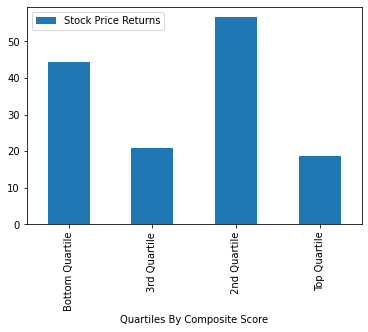

In [24]:
ranking_df_w_quartiles.plot.bar()
display(ranking_df_w_quartiles)
countNA=str(ranking_df.shape[0] - ranking_df.dropna().shape[0])
display("Note: There are "+countNA+" stocks out of the total "+str(len(ranking_df))+" scored stocks without Stock Price info which were ignored in the aggregation")

In [25]:
ranking_df

,Profit Margin,Return on Assets (ttm),Return on Equity (ttm),Total Debt/Equity (mrq),Composite Score,Rank By Composite Score,Market Cap (intraday) 5,Adj Close 2021-04-13,Adj Close 2020-04-13,Stock Price Returns,Quartiles By Composite Score
ADN.SI,1.511811,0.468895,0.460773,-0.535691,0.992562,1.0,,1.410,1.0909,29.3,Top Quartile
BKY.SI,0.601409,0.637419,0.558135,3.673821,0.903596,2.0,,0.405,0.3415,18.6,Top Quartile
5CP.SI,0.845280,1.362221,1.141332,0.253001,0.896957,3.0,,0.245,0.2715,-9.8,Top Quartile
1J3.SI,0.600637,0.964027,0.715374,0.116907,0.611550,4.0,,0.189,0.1776,6.4,Top Quartile
CC3.SI,0.410530,0.802960,1.458731,-0.730171,0.545343,5.0,,1.320,1.3784,-4.2,Top Quartile
S59.SI,0.528865,0.072193,0.403817,1.186799,0.523981,6.0,,2.420,1.7743,36.4,Top Quartile
B26.SI,0.277018,0.770150,0.813710,0.913114,0.497279,7.0,,0.260,0.1896,37.1,Top Quartile
1J5.SI,0.338501,0.600135,0.824419,0.388390,0.466837,8.0,,0.320,0.1970,62.4,2nd Quartile
BHU.SI,0.507256,0.201941,0.367306,0.488998,0.446909,9.0,,0.520,0.3321,56.6,2nd Quartile
42N.SI,0.417733,0.643384,0.885271,-0.578593,0.434173,10.0,,0.078,0.0610,27.9,2nd Quartile


In [26]:
#A negative number indicates that something is wrong with your data—perhaps you forgot to reverse score some items. 
#The general rule of thumb is that a Cronbach’s alpha of .70 and above is good, .80 and above is better, and .90 and above is best

display("Cronbach's Alpha (Internal Consistency) = "+str(round(cronbachalpha,3)))

"Cronbach's Alpha (Internal Consistency) = 0.677"

Correlation Coefficient =-0.457


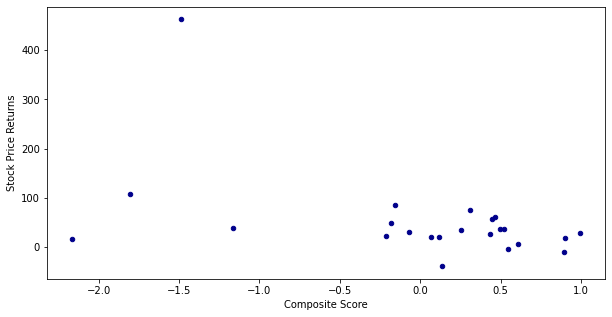

In [27]:
ranking_df.plot.scatter(x='Composite Score',y='Stock Price Returns',c='DarkBlue',figsize=(10,5))
print("Correlation Coefficient ="+str((round(ranking_df.corr()['Stock Price Returns'].loc['Composite Score'],3))))

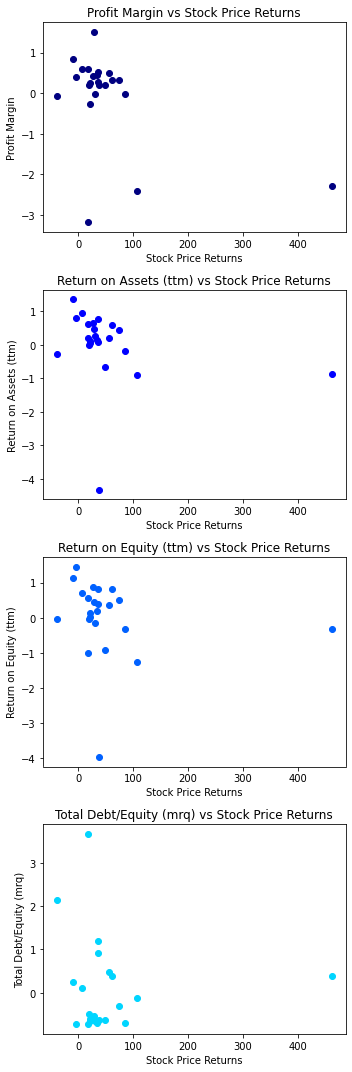

'Correlation Coefficients'

Profit Margin             -0.498701
Return on Assets (ttm)    -0.244655
Return on Equity (ttm)    -0.152806
Total Debt/Equity (mrq)   -0.026135
Name: Stock Price Returns, dtype: float64

In [28]:
#function to plot in a grid the correlation between each factor and the Stock Returns
def correlation(ranking_df,listOfMetrics, n_rows, n_cols,imagecounter):
    jet= plt.get_cmap('jet')
    colors = iter(jet(np.linspace(0,1,10)))
    fig = plt.figure(figsize=(5,15))
    #fig = plt.figure(figsize=(14,9))
    for i, var in enumerate(listOfMetrics):
        ax = fig.add_subplot(n_rows,n_cols,i+1)
        asset = ranking_df.loc[:,var]
        ax.scatter(ranking_df['Stock Price Returns'], asset, color = next(colors))
        ax.set_xlabel('Stock Price Returns')
        ax.set_ylabel("{}".format(var))
        ax.set_title(var +" vs Stock Price Returns")
    fig.tight_layout()
    #plt.savefig(f'static/factoranalysis/{imagecounter}_02_CorrelByFactor.png')
    plt.show()

correlation(ranking_df,listOfMetrics, len(listOfMetrics),1,'0123456')

display("Correlation Coefficients")
display(ranking_df.corr()['Stock Price Returns'].loc[listOfMetrics])
    

'Multiple Linear Regression Coefficients & Intercept'

Feature,Coefficients
Profit Margin,-1.680000
Return on Assets (ttm),-28.340000
Return on Equity (ttm),3.750000
Total Debt/Equity (mrq),-6.230000


'Intercept = 38.22'

'Mean Absolute Error In Stock Returns % = 118.7'

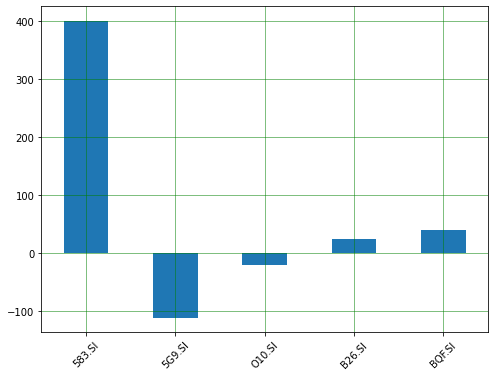

In [29]:
#Extends the above approach by conducting a Multivariate Linear Regression on the Factors as features that predict the Stock Returns
#CAUTION : Will not work with small sample sizes ! 

#Adapted from https://financetrain.com/multivariate-linear-regression-in-python-with-scikit-learn-library/

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
    
ranking_df_w_na_removed=ranking_df.dropna()

train, test = train_test_split(ranking_df_w_na_removed, test_size=0.2)

LinReg = LinearRegression()
 
X_train = train[listOfMetrics]
 
Y_train = train["Stock Price Returns"]
 
LinReg.fit(X_train,Y_train)   

X_test = test[listOfMetrics].values 

Y_test = test["Stock Price Returns"].values 

close_predictions = LinReg.predict(X_test)   

LinearRegressionCoeff_df=pd.DataFrame({"Feature":X_train.columns.tolist(),"Coefficients":LinReg.coef_})

display("Multiple Linear Regression Coefficients & Intercept")
display(LinearRegressionCoeff_df.round(2).style.hide_index())
display("Intercept = "+str(round(LinReg.intercept_,2)))

mae = sum(abs(close_predictions - test["Stock Price Returns"].values)) / test.shape[0]

display('Mean Absolute Error In Stock Returns % = '+str(round(mae,1)))

df = pd.DataFrame({'Symbol':test.index,'Actual': Y_test, 'Predicted': close_predictions})

error = df['Actual'] - df['Predicted']
 
# Plot the error term between the actual and predicted values for the last 25 days
 
error.plot(kind='bar',figsize=(8,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xticks(range(0,len(test.index)), test.index,rotation=45)
plt.show()